In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# Utilitarias
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Markdown

import pickle

In [ ]:
# Importa base de datos
df_entregas = pd.read_csv('deliveries_2021.csv').iloc[:, 0:] #Importar archivo de shippers


display(Markdown("**Base de datos conjunto de entrenamiento**: Tiene {} columnas y {} filas ".format(df_entregas.shape[1], df_entregas.shape[0])))
display(Markdown("**Algunas observaciones de la base de datos original**"))
df_entregas

**Base de datos conjunto de entrenamiento**: Tiene 7 columnas y 209 filas 

**Algunas observaciones de la base de datos original**

period  ... total_value_driver
0    2021-05  ...       2.759490e+04
1    2021-01  ...       4.275818e+04
2    2021-01  ...       1.464592e+06
3    2021-01  ...       2.553939e+05
4    2021-01  ...       4.048946e+04
..       ...  ...                ...
204  2021-01  ...       1.710846e+04
205  2021-01  ...       1.617020e+06
206  2021-06  ...       8.523200e+04
207  2021-01  ...       4.450217e+04
208  2021-01  ...       1.846471e+05

[209 rows x 7 columns]

In [ ]:
df_entregas.dtypes

period                 object
name                   object
deliveries              int64
last_delivery          object
plan_type              object
total_value           float64
total_value_driver    float64
dtype: object

In [ ]:
df_entregas['last_delivery']= pd.to_datetime(df_entregas['last_delivery'])

In [ ]:
df_entregas.dtypes

period                        object
name                          object
deliveries                     int64
last_delivery         datetime64[ns]
plan_type                     object
total_value                  float64
total_value_driver           float64
dtype: object

In [ ]:
df_entregas['month_active'] = df_entregas['last_delivery'].dt.month

In [ ]:
df_entregas

period  ... month_active
0    2021-05  ...            5
1    2021-01  ...            8
2    2021-01  ...            6
3    2021-01  ...            9
4    2021-01  ...            4
..       ...  ...          ...
204  2021-01  ...            1
205  2021-01  ...           12
206  2021-06  ...            8
207  2021-01  ...            7
208  2021-01  ...           12

[209 rows x 8 columns]

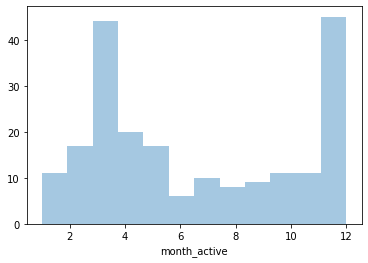

In [ ]:
sns.distplot(df_entregas['month_active'], kde=False, bins=12)

count     209.000000
mean      112.444976
std       324.167036
min         1.000000
25%         3.000000
50%        16.000000
75%        59.000000
max      2808.000000
Name: deliveries, dtype: float64


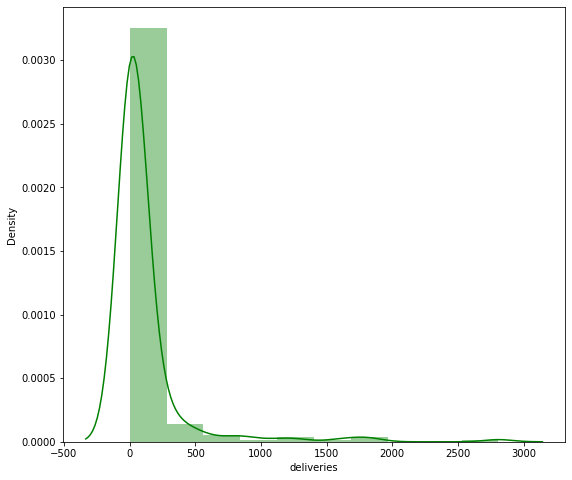

In [ ]:
print(df_entregas['deliveries'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df_entregas['deliveries'], color='g', bins=10, hist_kws={'alpha': 0.4});

In [ ]:
df_entregas.sort_values(by=["deliveries"], ascending=[False]).head(10)

period  ... month_active
87   2021-01  ...           12
163  2021-01  ...           10
169  2021-01  ...           12
29   2021-06  ...           12
99   2021-01  ...           12
84   2021-01  ...           12
132  2021-01  ...           12
104  2021-05  ...           12
43   2021-01  ...            9
42   2021-04  ...           12

[10 rows x 8 columns]

In [ ]:
df_entregas['churn_2021'] = (df_entregas["last_delivery"] < pd.to_datetime('2021-07-01 00:00:00')) * 1
df_entregas['active_2021'] = (df_entregas["last_delivery"] >= pd.to_datetime('2021-07-01 00:00:00')) * 1

df_entregas.head()

period                               name  ...  churn_2021 active_2021
0  2021-05                                ADR  ...           1           0
1  2021-01                    AlfaForni Chile  ...           0           1
2  2021-01                       ALPAKA Chile  ...           1           0
3  2021-01                         Ambar Deco  ...           0           1
4  2021-01  Ancares Asesorias y Servicios SpA  ...           1           0

[5 rows x 10 columns]

In [ ]:
df_entregas['churn_2021'].mean()


0.5502392344497608

In [ ]:
df_entregas['active_2021'].mean()

0.44976076555023925

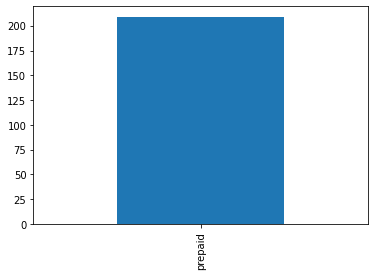

In [ ]:
df_entregas['plan_type'].value_counts().plot.bar()

In [ ]:
df_entregas['deliveries'].sum()

23501

In [ ]:
df_entregas['month_active'].value_counts()

12    45
3     44
4     20
5     17
2     17
11    11
10    11
1     11
7     10
9      9
8      8
6      6
Name: month_active, dtype: int64

In [ ]:
companies_month = df_entregas.groupby(["month_active", "name"])["deliveries"].sum()

In [ ]:
df_month = pd.DataFrame(companies_month)

In [ ]:
with pd.option_context('display.max_rows', None,):
    print(df_month)

                                                       deliveries
month_active name                                                
1            Botilleria Don Leo                                 1
             Comercial CGB  Ltda                                3
             Convictus                                          3
             GSMPRO                                            86
             Gap Flow ltda                                      1
             IKSEG                                              1
             Kota Mochilas                                      1
             Print3x                                            4
             Renox                                              2
             SALVAJE                                            1
             Wauke SPA                                          6
2            Cargosud spa                                       1
             Conservas de la Tita                               1
          

In [ ]:
df_month

deliveries
month_active name                           
1            Botilleria Don Leo            1
             Comercial CGB  Ltda           3
             Convictus                     3
             GSMPRO                       86
             Gap Flow ltda                 1
...                                      ...
12           Vibra SpA                    86
             Yerka                       299
             Zyggo                        61
             cecilia diaz                  4
             pontetu spa                 483

[209 rows x 1 columns]

In [ ]:
df_entregas['total_value'].sum()

96326071.01635742

In [ ]:
df_entregas['total_value_driver'].sum()

70474478.08691406

In [ ]:
revenue_cost = (df_entregas['total_value'].sum() - df_entregas['total_value_driver'].sum())/df_entregas['total_value'].sum()


In [ ]:
revenue_cost * 100

26.83758680975727